# Clasificación usando Imágenes

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
import os


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      cm.astype(int)
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".0f"))
    else:
      cm.astype(int)
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',np.int(classes[0]),classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".0f")) 

In [3]:
from skimage.feature import hog
from skimage import data, color, exposure
from PIL import ImageOps, Image
from sklearn.ensemble import RandomForestClassifier

def extract_histo(img):
    values_r, _ = np.histogram(img[:,:,0].ravel(), bins=256, range=(0.0, 256))
    values_g, _ = np.histogram(img[:,:,1].ravel(), bins=256, range=(0.0, 256))
    values_b, _ = np.histogram(img[:,:,2].ravel(), bins=256, range=(0.0, 256))
    return np.concatenate((values_r, values_g, values_b))

def extract_pixels(img, flatten=True):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)
    test_img = test_img.convert('L')
    if flatten:
        return np.array(test_img).flatten()
    return np.array(test_img)

def extract_hog(img):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS) #
    image = color.rgb2gray(np.array(test_img))

    fd = hog(image, orientations=8, pixels_per_cell=(28, 28),
                    cells_per_block=(1, 1), visualise=False)
    return fd

In [8]:
import os
arr = os.listdir('C:/Users/ASUS/Downloads/birds/')
print(arr)

['egret', 'mandarin', 'owl', 'puffin', 'toucan', 'wood_duck']


In [14]:
img=mpimg.imread('C:/Users/ASUS/Downloads/birds/owl/owl100.jpg')

En esta segunda parte vamos a trabajar usando un par de conjuntos de clasificación un poco más complicados. A continuación trabajaremos con el conjunto de datos `birds`. `Birds` contiene las imágenes de 600 aves que pertenecen a 6 especies. Cada una con 100 imágenes.

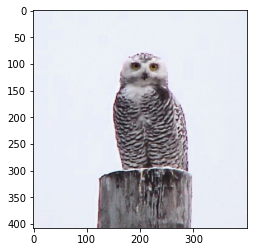

In [15]:
imgplot = plt.imshow(img)

Armamos el conjunto de datos:

In [20]:
with open('birds_f_numbers.txt', 'r') as f:
    f = f.readlines()

In [21]:
bird_classes = ['egr', 'man', 'owl', 'puf', 'tou', 'wod']

In [22]:
train_test_indices = [x.strip() for x in f[7:]]
train_test_indices = [x for x in train_test_indices if len(x)>0]

Clases

In [23]:
class_to_ix = {cls:i for i, cls in enumerate(bird_classes)}

print(class_to_ix)

{'egr': 0, 'man': 1, 'owl': 2, 'puf': 3, 'tou': 4, 'wod': 5}


In [26]:
train_files = []
val_files = []
test_files = []
y_train = []
y_val = []
y_test = []


for i, idx_class in zip(range(0, 606, 101), bird_classes):
    bird_class = train_test_indices[i]
    train_files.extend([os.path.join(os.getcwd(), 
                              'Downloads', 
                              'birds', 
                              bird_class, 
                              idx_class + train_test_indices[x].zfill(3) + '.jpg') for x in range(i+1, i+21, 1)])
    y_train.extend([class_to_ix[idx_class]]*20)
    val_files.extend([os.path.join(os.getcwd(), 
                              'Downloads', 
                              'birds', 
                              bird_class, 
                              idx_class + train_test_indices[x].zfill(3) + '.jpg') for x in range(21+i, i+51, 1)])
    y_val.extend([class_to_ix[idx_class]]*30)
    test_files.extend([os.path.join(os.getcwd(), 
                              'Downloads', 
                              'birds', 
                              bird_class, 
                              idx_class + train_test_indices[x].zfill(3) + '.jpg') for x in range(51+i, i+101, 1)])
    y_test.extend([class_to_ix[idx_class]]*50)

In [27]:
train = [mpimg.imread(filename) for filename in train_files]
val = [mpimg.imread(filename) for filename in val_files]
test = [mpimg.imread(filename) for filename in test_files]

In [40]:
!pip install opencv-python

Definimos una función para transformar cualquier imagen a escala de grises

In [43]:
import cv2
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

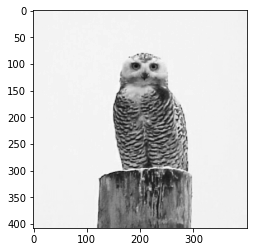

In [44]:
imgplot = plt.imshow(to_gray(img), cmap='gray')

También será útil una función que permita escalar las imágenes

Cambie `fun` por la función de extracción de características deseada

# Extracción de características

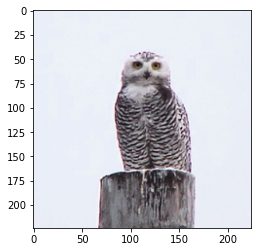

In [45]:
from PIL import Image 
t_img = Image.fromarray(img)

new_width  = 224
new_height = 224
test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)

plt.imshow(test_img)

In [120]:
from skimage.feature import hog
from skimage import data, color, exposure
from PIL import ImageOps, Image
from sklearn.ensemble import RandomForestClassifier

def extract_histo(img):
    values_r, _ = np.histogram(img[:,:,0].ravel(), bins=256, range=(0.0, 256))
    values_g, _ = np.histogram(img[:,:,1].ravel(), bins=256, range=(0.0, 256))
    values_b, _ = np.histogram(img[:,:,2].ravel(), bins=256, range=(0.0, 256))
    return np.concatenate((values_r, values_g, values_b))

def extract_pixels(img, flatten=True):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)
    test_img = test_img.convert('L')
    if flatten:
        return np.array(test_img).flatten()
    return np.array(test_img)

def extract_hog(img):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS) #
    image = color.rgb2gray(np.array(test_img))

    fd = hog(image, orientations=8, pixels_per_cell=(18, 18),
                    cells_per_block=(1, 1), visualise=False)
    return fd

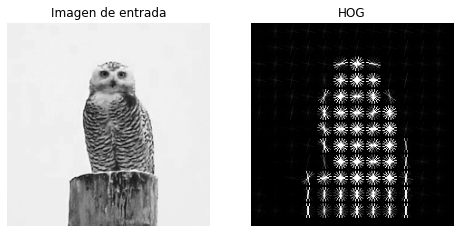

In [121]:
from skimage.feature import hog
from skimage import data, color, exposure


image = color.rgb2gray(np.array(test_img))

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(18, 18),cells_per_block=(1, 1), visualize=True )
##                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Imagen de entrada')
ax1.set_adjustable('box')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG')
ax1.set_adjustable('box')
plt.show()

In [122]:
print('Tamaño vector de características: {}'.format(fd.shape))

Tamaño vector de características: (1152,)


In [123]:
fun = extract_pixels

X_train = np.array([fun(img) for img in train])

In [124]:
X_val = np.array([fun(img) for img in val])
X_test = np.array([fun(img) for img in test])

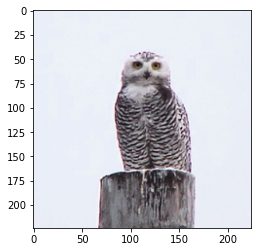

In [125]:
from PIL import Image 
t_img = Image.fromarray(img)

new_width  = 224
new_height = 224
test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)

plt.imshow(test_img)

In [126]:
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [127]:
print(X.shape)
print(X_test.shape)

(300, 50176)
(300, 50176)


In [145]:
clf = RandomForestClassifier(n_estimators=800, max_features=0.05, n_jobs=-1, random_state=42)
#clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [146]:
clf.fit(X, y)

RandomForestClassifier(max_features=0.05, n_estimators=800, n_jobs=-1,
                       random_state=42)

In [147]:
clf.score(X_test, y_test)

0.48333333333333334

In [154]:
datos_X_test=y_test.copy()
datos_X_test

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [153]:
datos_X_predict=clf.predict(X_test)
datos_X_predict

array([0, 0, 5, 0, 0, 0, 4, 0, 0, 0, 4, 0, 5, 0, 0, 4, 0, 1, 0, 0, 0, 4,
       1, 4, 2, 4, 0, 0, 2, 2, 5, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 0, 2, 4,
       0, 0, 0, 0, 1, 4, 5, 5, 1, 4, 5, 1, 1, 3, 0, 1, 5, 5, 5, 1, 2, 4,
       5, 5, 1, 1, 1, 1, 3, 1, 4, 5, 5, 5, 1, 1, 5, 1, 0, 0, 5, 2, 1, 4,
       1, 5, 1, 3, 1, 1, 5, 5, 1, 1, 5, 3, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5,
       4, 2, 2, 2, 2, 2, 2, 2, 0, 4, 2, 0, 4, 1, 1, 0, 2, 0, 2, 2, 1, 4,
       2, 2, 2, 0, 2, 2, 2, 5, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 3, 3, 5,
       3, 3, 3, 5, 3, 1, 1, 0, 5, 4, 5, 2, 5, 3, 3, 1, 4, 0, 2, 1, 0, 2,
       1, 1, 2, 3, 1, 3, 0, 1, 1, 3, 2, 5, 3, 4, 5, 0, 4, 0, 5, 3, 0, 4,
       1, 3, 0, 5, 4, 0, 5, 0, 1, 2, 4, 3, 1, 4, 4, 1, 2, 5, 4, 4, 1, 4,
       2, 3, 4, 4, 4, 5, 1, 4, 1, 4, 5, 4, 4, 2, 3, 5, 2, 4, 1, 3, 4, 1,
       0, 4, 4, 4, 5, 4, 4, 4, 1, 5, 3, 5, 5, 5, 1, 5, 5, 5, 1, 5, 1, 1,
       1, 1, 1, 5, 5, 1, 5, 5, 5, 5, 4, 5, 5, 1, 0, 2, 1, 5, 0, 1, 5, 0,
       5, 5, 5, 5, 5, 3, 5, 5, 0, 5, 5, 5, 5, 1])

# RandomizedSearchCV

Exploremos el número de características usadas por RandomForest.

In [ ]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randfloat
from scipy.stats import randint as sp_randint

param_dist = {"max_features": sp_randfloat()}

clf = RandomForestClassifier(n_estimators=100)

#n_iter_search = 40
n_iter_search = 5

random_search = RandomizedSearchCV(clf, random_state=42, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, 
                                   n_jobs=-1, verbose=2)

random_search.fit(X, y)
random_search.score(X_test, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
